In [1]:
import pandas as pd

In [2]:
import json

In [3]:
with open('28-09_22-11_alldata.json','r') as j_in:
    data = json.load(j_in)

In [4]:
def json_unwrap(data: dict):
    """
    accepts a dict json gathered from asystom dashboard
    and outputs a list of pd.DataFrame tables 
    """
    
    names = [data['results'][n]['series'][0]['name'] for n in range(4)]
    cols = [data['results'][n]['series'][0]['columns'] for n in range(4)]
    dfs = [pd.DataFrame(data['results'][i]['series'][0]['values'],columns=cols[i]) for i in range(4)]
    for i in range(4): dfs[i].name = names[i]
    
    return dfs

In [5]:
dfs = json_unwrap(data)

In [6]:
dfs[0].name

'Signature_Drift'

In [7]:
dfs[1].name

'Signature'

In [8]:
df_0 = dfs[0].copy()
df_1 = dfs[1].copy()

In [9]:
numeric_df_0 = df_0.select_dtypes('number')
numeric_df_1 = df_1.select_dtypes('number')

In [10]:
numeric_df_0.drop('time',axis=1,inplace=True)
numeric_df_1.drop('time',axis=1,inplace=True)

/Users/davide/venvs/smart_elevator/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [14]:
#https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
#distortion = It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.
#inertia = It is the sum of squared distances of samples to their closest cluster center.
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.cluster import KMeans

In [15]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1,10)

for k in tqdm(K):
    #building and fitting model
    kmean_model = KMeans(init='k-means++',n_clusters=k)
    kmean_model.fit(numeric_df_0)
    
    distortions.append(sum(np.min(cdist(numeric_df_0, kmean_model.cluster_centers_,
                                        'euclidean'), axis=1)) / numeric_df_0.shape[0])
    inertias.append(kmean_model.inertia_)
    
    mapping1[k] = sum(np.min(cdist(numeric_df_0, kmean_model.cluster_centers_,
                                   'euclidean'), axis=1)) / numeric_df_0.shape[0]
    mapping2[k] = kmean_model.inertia_

  0%|          | 0/9 [00:00<?, ?it/s]

In [16]:
for key, val in mapping1.items(): print(f'{key} : {val}')

1 : 116.98734834487095
2 : 15.040823672754742
3 : 11.991919132780048
4 : 9.684412637351322
5 : 8.631156046474482
6 : 8.593243323166986
7 : 7.957504527103763
8 : 7.938060709110189
9 : 7.4331420955502026


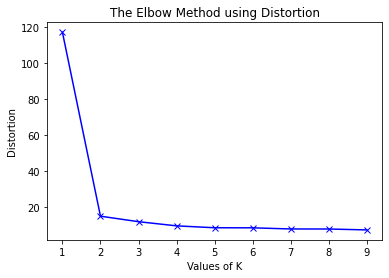

In [17]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [18]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 372557483.4743669
2 : 11590094.973421162
3 : 8299740.932564747
4 : 5484756.094277556
5 : 4054771.6512986943
6 : 3209951.640303239
7 : 2550882.306938329
8 : 2222911.4410970146
9 : 2040488.409765534


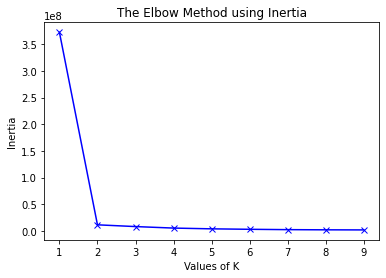

In [19]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [21]:
#kmeans with 4 
from sklearn.cluster import KMeans

kmeans_0 = KMeans(init='k-means++',n_clusters=4)
kmeans_1 = KMeans(init='k-means++',n_clusters=4)

clusters_df_0 = kmeans_0.fit(numeric_df_0)
clusters_df_1 = kmeans_1.fit(numeric_df_1)

set(kmeans_0.labels_)

{0, 1, 2, 3}

In [23]:
#Normalize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
sc = StandardScaler()
X_norm = sc.fit_transform(numeric_df_0)

#pca for visualization in 3 dimensions
pca = PCA(n_components=3)
components = pca.fit_transform(X_norm)

#explained variance of the 3 components (how much well we're able to see)
print(pca.explained_variance_ratio_)

var = pca.explained_variance_ratio_.sum()

fig = px.scatter_3d(components, 
                    x=0,y=1,z=2, 
                    color=kmeans_0.labels_,
                    labels = {'0':'PC1','1':'PC2','2':'PC3'}
                   )
fig.show()
fig.write_html('SignatureDrift_kmeans4_pca3d.html')

[0.32500242 0.1443437  0.11174129]


In [24]:
df_0.describe().T

count          mean           std           min           25%  \
time          24392.0  1.635735e+12  1.355514e+09  1.632822e+12  1.634658e+12   
mileage       24392.0  4.254387e+02  1.213956e+02  2.560000e+02  2.570000e+02   
s_00          24392.0 -1.081077e+00  5.437294e+00 -1.658286e+01 -1.572533e+00   
s_01          24392.0  1.696139e-01  5.431462e+00 -8.867819e+00 -4.716411e+00   
s_02          24392.0 -1.864429e+00  5.417199e+00 -1.291119e+01 -6.140764e+00   
s_03          24392.0 -5.558891e-01  4.208148e+00 -5.422293e+00 -3.330282e+00   
s_04          24392.0  9.517119e-02  4.001590e+00 -4.181048e+00 -1.667887e+00   
s_05          24392.0  3.868838e-01  3.351581e+00 -2.965324e+00 -6.901495e-01   
s_06          24392.0  5.281561e-01  3.567341e+00 -3.276837e+00 -6.423667e-01   
s_07          24392.0  5.207596e-01  3.570846e+00 -2.733349e+00 -4.727084e-01   
s_08          24392.0  5.039552e-01  3.335567e+00 -2.065630e+00 -4.199443e-01   
s_09          24392.0  2.348787e-01  1.462941e+00 -1.836805e+00 -3.078508e-01   
s_10          24392.0 -2.194594e+00  5.019713e+00 -3.051198e+01 -4.808158e+00   
s_11          24392.0  2.667551e-03  8.684341e+00 -2.749214e+01 -1.096818e+00   
s_12          24392.0  6.471644e-01  4.554011e+00 -1.250774e+01 -1.093156e+00   
s_13          24392.0 -2.586931e-01  7.895300e+00 -3.079977e+01  1.008421e+00   
s_14          24392.0  1.565847e+00  5.278574e+00 -1.304658e+01 -9.454108e-01   
s_15          24392.0 -5.695154e-01  6.741496e+00 -2.063355e+01 -1.462119e+00   
s_16          24392.0  9.779063e-02  1.380729e+00 -1.740492e+00 -5.251111e-01   
s_17          24392.0 -4.369477e-01  7.813535e-01 -2.236210e+00 -9.590295e-01   
s_18          24392.0 -3.186626e-02  2.829128e-01 -1.222007e+00 -2.128634e-01   
s_19          24392.0 -7.199952e-02  2.944557e-01 -1.241884e+00 -2.645433e-01   
sonic_custom  24392.0  1.184405e+00  2.095154e-01  1.217869e-01  9.988232e-01   
sonic_rmslog  24392.0  5.091567e-01  3.831934e+00 -1.307453e+01 -3.073087e-01   
temp          24392.0  9.965419e-01  8.515437e-02  7.591653e-01  9.609117e-01   
vib_x_acc     24392.0  1.307930e+00  1.150527e+00  3.518268e-01  1.067155e+00   
vib_x_f1      24392.0  9.266819e-01  4.484083e-01  0.000000e+00  1.000000e+00   
vib_x_f2      24392.0  9.322769e-01  5.225567e-01  0.000000e+00  1.000000e+00   
vib_x_f3      24392.0  9.185310e-01  4.690266e-01  0.000000e+00  1.000000e+00   
vib_x_kurt    24392.0  7.977290e-01  4.328781e-01  2.533032e-01  5.105195e-01   
vib_x_peak    24392.0  1.106574e+00  2.388092e+00  1.875000e-01  5.682951e-01   
vib_x_root    24392.0  9.849670e-01  5.321027e-01  0.000000e+00  8.810034e-01   
vib_x_vel     24392.0  2.039269e+00  1.236710e+00  1.067806e-01  1.406167e+00   
vib_y_acc     24392.0  1.152780e+00  9.226708e-01  2.639916e-01  9.228571e-01   
vib_y_f1      24392.0  8.202078e-01  2.702849e+00  0.000000e+00  3.511204e-01   
vib_y_f2      24392.0  8.521129e-01  3.535847e+00  0.000000e+00  2.238671e-01   
vib_y_f3      24392.0  8.053488e-01  4.682533e+00  0.000000e+00  2.310231e-01   
vib_y_kurt    24392.0  9.449916e-01  4.489144e-01  3.609561e-01  6.795481e-01   
vib_y_peak    24392.0  1.124705e+00  1.394230e+00  1.627339e-01  7.587469e-01   
vib_y_root    24392.0  8.111946e-01  6.332106e-01  0.000000e+00  5.319542e-01   
vib_y_vel     24392.0  1.649224e+00  9.195142e-01  1.206541e-01  1.148941e+00   
vib_z_acc     24392.0  1.366555e+00  1.297719e+00  3.849238e-01  9.801587e-01   
vib_z_f1      24392.0  1.734820e+00  2.571010e+00  0.000000e+00  1.000000e+00   
vib_z_f2      24392.0  2.035420e+00  3.689848e+00  0.000000e+00  1.000000e+00   
vib_z_f3      24392.0  1.267848e+00  1.431326e+00  0.000000e+00  1.000000e+00   
vib_z_kurt    24392.0  8.908684e-01  5.988660e-01  3.071842e-01  6.281564e-01   
vib_z_peak    24392.0  1.209945e+00  2.826248e+00  1.979947e-01  6.447519e-01   
vib_z_root    24392.0  1.217916e+00  1.110041e+00  0.000000e+00  1.000000e+00   
vib_z_vel     24392.0  1.659145e+00  1.317078e+

In [25]:
numeric_df_0['kmeans_label'] = kmeans_0.labels_
df_0['kmeans_label'] = kmeans_0.labels_

/var/folders/jf/cgdt2qc966vg1_ql1513k7qr0000gq/T/ipykernel_47589/2671496079.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
numeric_df_1['kmeans_label'] = kmeans_1.labels_
df_1['kmeans_label'] = kmeans_1.labels_

/var/folders/jf/cgdt2qc966vg1_ql1513k7qr0000gq/T/ipykernel_47589/2960149168.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [32]:
means_df_0 = numeric_df_0.groupby('kmeans_label').mean()
means_df_1 = numeric_df_1.groupby('kmeans_label').mean()

In [33]:
'''
kiga = Kmeans Intra Group Average
'''

means_df_0.columns = ['kiga_'+s for s in list(means_df_0.columns)]
means_df_1.columns = ['kiga_'+s for s in list(means_df_1.columns)]

In [34]:
means_df_0.head()

kiga_mileage  kiga_s_00  kiga_s_01  kiga_s_02  kiga_s_03  \
kmeans_label                                                             
0               257.005416   1.981047  -4.356987  -6.566367  -3.621906   
1               512.803597  -1.182552   1.769055  -0.246191  -0.156422   
2               256.716279   8.670522  15.758058  18.207892  19.225700   
3               256.000575 -15.045063  -7.419351 -11.267400  -3.937904   

              kiga_s_04  kiga_s_05  kiga_s_06  kiga_s_07  kiga_s_08  ...  \
kmeans_label                                                         ...   
0             -1.967300  -0.891866  -0.881842   0.042120  -0.024970  ...   
1              0.045785   0.121702   0.283386  -0.146903  -0.133499  ...   
2             19.862525  17.269230  18.484617  18.637222  17.408896  ...   
3             -2.435452  -1.302623  -1.449139  -0.693588  -0.224875  ...   

              kiga_vib_y_vel  kiga_vib_z_acc  kiga_vib_z_f1  kiga_vib_z_f2  \
kmeans_label                                                                 
0                   2.642860        1.389041       3.791706       4.933983   
1                   1.388117        1.189183       1.000000       1.000000   
2                   2.881111        6.477649       5.282566       6.205645   
3                   0.182142        0.403895       0.000000       0.000000   

              kiga_vib_z_f3  kiga_vib_z_kurt  kiga_vib_z_peak  \
kmeans_label                                                    
0                  2.071534         0.451623         0.547299   
1                  1.000000         0.990702         1.155303   
2                  3.487074         2.476367         8.588013   
3                  0.000000         0.630079         0.247269   

              kiga_vib_z_root  kiga_vib_z_vel  kiga_vibra_custom  
kmeans_label                                                      
0                    1.829318        1.713211                1.0  
1                    1.000000        1.757382                1.0  
2                    3.682999        2.539604                1.0  
3                    0.000000        0.138015                1.0  

[4 rows x 49 columns]

In [35]:
wide_df_0 = pd.merge(df_0,means_df_0,left_on='kmeans_label',right_on='kmeans_label',how='left')
wide_df_1 = pd.merge(df_1,means_df_1,left_on='kmeans_label',right_on='kmeans_label',how='left')

In [39]:
wide_df_0.to_feather('28-09_22-11_Signature_Drift_kmeans4_enriched.feather')
wide_df_1.to_feather('28-09_22-11_Signature_kmeans4_enriched.feather')

In [40]:
wide_df_0.to_json('28-09_22-11_Signature_Drift_kmeans4_enriched.json')
wide_df_1.to_json('28-09_22-11_Signature_kmeans4_enriched.json')